# Import required libraries

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
import numpy as np
import pandas as pd
from tensorflow import keras as k

import cv2
from PIL import Image
from keras.preprocessing.image import img_to_array, ImageDataGenerator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Flatten, Conv2D, Dropout, Dense

# Loading Dataset and Preprocessing

[Image Thresholding](https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html)

[Closing, Dilation](https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html)

[Gaussian Blur](https://docs.opencv.org/3.4/d4/d13/tutorial_py_filtering.html)

In [3]:
X=[]
y=[]

# Since there are subfolders inside the input directory, we've used nested loops
for dirname, _, filenames in os.walk('/content/test'):
    for filename in filenames:
        path=os.path.join(dirname, filename)

# Preprocessing the image:
# - read image
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

# - Adaptive Threshold: For every pixel, the same threshold value is applied. If the pixel value
# is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value
# It removes the greyish tinge off the image.
        image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)

# - Closing: It is useful in closing small holes inside the foreground objects,
# or small black points on the object
        kernel = np.ones((5,5),np.uint8)
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

# - Dilation: So it increases the white region in the image or
# size of foreground object increases
        kernel = np.ones((2,2),np.uint8)
        image = cv2.dilate(image, kernel, iterations = 1)

# - Blur: As in one-dimensional signals, images also can be filtered with various low-pass filters (LPF), high-pass filters (HPF), etc.
# LPF helps in removing noise, blurring images, etc. HPF filters help in finding edges in images.
        image = cv2.GaussianBlur(image, (5,5), 0)


# Splitting up the image into sections of each character
        x=[image[10:50,30:50],image[10:50,50:70],
                 image[10:50,70:90],image[10:50,90:110],image[10:50,110:130]]

# Labelling segments with the image name
        for i in range(5):
            X.append(img_to_array(Image.fromarray(x[i])))
            y.append(path[len(path)-9:len(path)-4][i])
X=np.array(X)
y=np.array(y)

# Scaling X values; Label Encoding and One Hot Encoding the labels

In [4]:
X=X.astype('float32')
X/=255

y_le = LabelEncoder().fit_transform(y)
y_ohe = OneHotEncoder(sparse = False).fit_transform(y_le.reshape(len(y_le),1))

X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size = 0.2, random_state = 42)

row, col = X.shape[1],X.shape[2]
categories = y_ohe.shape[1]

info = {y_le[i] : y[i] for i in range(len(y))}

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Creating the CNN architecture

In [5]:
model = Sequential()

model.add(Conv2D(filters=16,kernel_size=(3,3), padding='same', input_shape=(row,col,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=16,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))


model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(1500))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(categories))
model.add(Activation("softmax"))

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam' ,
              metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 20, 16)        160       
                                                                 
 activation (Activation)     (None, 40, 20, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 20, 10, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 10, 16)        2320      
                                                                 
 activation_1 (Activation)   (None, 20, 10, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 5, 16)         0         
 g2D)                                                   

# Fitting and training data into model

In [6]:
batch_size = 150
epochs = 200

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          shuffle=True)

Epoch 1/200
29/29 [==============================] - 8s 206ms/step - loss: 2.9031 - accuracy: 0.1009 - val_loss: 2.8149 - val_accuracy: 0.0860
Epoch 2/200
29/29 [==============================] - 5s 179ms/step - loss: 2.3733 - accuracy: 0.2680 - val_loss: 1.8614 - val_accuracy: 0.4364
Epoch 3/200
29/29 [==============================] - 6s 224ms/step - loss: 1.8097 - accuracy: 0.4629 - val_loss: 1.4878 - val_accuracy: 0.6112
Epoch 4/200
29/29 [==============================] - 3s 100ms/step - loss: 1.5093 - accuracy: 0.5689 - val_loss: 1.2361 - val_accuracy: 0.6804
Epoch 5/200
29/29 [==============================] - 3s 95ms/step - loss: 1.3129 - accuracy: 0.6325 - val_loss: 1.0735 - val_accuracy: 0.7224
Epoch 6/200
29/29 [==============================] - 3s 98ms/step - loss: 1.1795 - accuracy: 0.6792 - val_loss: 0.9299 - val_accuracy: 0.7411
Epoch 7/200
29/29 [==============================] - 4s 126ms/step - loss: 1.0634 - accuracy: 0.7072 - val_loss: 0.8564 - val_accuracy: 0.7720
E

# Evaluating performance of the model

In [7]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

34/34 [==============================] - 0s 9ms/step - loss: 0.6009 - accuracy: 0.8841
Test loss: 0.6009460091590881
Test accuracy: 0.8841121792793274


# Prediction Function:

**The purpose of this function is to process raw images into model-comprehensible data for better prediction. As we've done in data preprocessing**

In [8]:
def pred (img_path) :

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

    image = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
    kernel = np.ones((5,5),np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.dilate(image, kernel, iterations = 1)
    image = cv2.GaussianBlur(image, (5,5), 0)


    x = [image[10:50, 30:50], image[10:50, 50:70], image[10:50, 70:90],
                  image[10:50, 90:110], image[10:50, 110:130]]

    X_pred = []
    for i in range(5) :
        X_pred.append(img_to_array(Image.fromarray(x[i])))

    X_pred = np.array(X_pred)
    X_pred/= 255.0

    y_pred = model.predict(X_pred)
    y_pred = np.argmax(y_pred, axis = 1)

    print('Prediction: ', end='')
    for res in y_pred :
        print(info[res], end='')

    print('\nActual:    ', img_path[len(img_path)-9:len(img_path)-4])

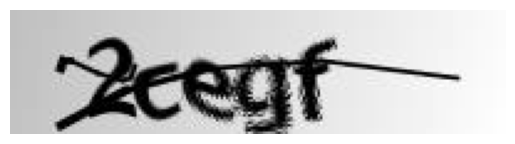

1/1 [==============================] - 0s 34ms/step
Prediction: 2cegf
Actual:     ion/a


In [19]:
pred('../content/testare predict function/a.png')

In [ ]:
model.save('captcha_recognizer.h5')